# Classificação de Texto - 20 Newsgroups
## Comparação MultinomialNB com e sem Priors

**Objetivo:** Comparar o desempenho do classificador MultinomialNB com e sem priors usando TFIDF e validação cruzada 10-fold no dataset 20 newsgroups.

**Dataset:** 20 newsgroups - coleção de aproximadamente 20.000 documentos de newsgroups divididos em 20 categorias diferentes.

## 1. Importação das Bibliotecas

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento do Dataset 20 Newsgroups

In [16]:
# Carregando o dataset completo
print("Carregando o dataset 20 newsgroups...")
newsgroups = fetch_20newsgroups(subset='all', 
                                remove=('headers', 'footers', 'quotes'),
                                random_state=42)

# Informações sobre o dataset
print(f"\nNúmero total de documentos: {len(newsgroups.data)}")
print(f"Número de categorias: {len(newsgroups.target_names)}")
print(f"\nCategorias disponíveis:")
for i, category in enumerate(newsgroups.target_names):
    print(f"  {i}: {category}")

Carregando o dataset 20 newsgroups...

Número total de documentos: 18846
Número de categorias: 20

Categorias disponíveis:
  0: alt.atheism
  1: comp.graphics
  2: comp.os.ms-windows.misc
  3: comp.sys.ibm.pc.hardware
  4: comp.sys.mac.hardware
  5: comp.windows.x
  6: misc.forsale
  7: rec.autos
  8: rec.motorcycles
  9: rec.sport.baseball
  10: rec.sport.hockey
  11: sci.crypt
  12: sci.electronics
  13: sci.med
  14: sci.space
  15: soc.religion.christian
  16: talk.politics.guns
  17: talk.politics.mideast
  18: talk.politics.misc
  19: talk.religion.misc

Número total de documentos: 18846
Número de categorias: 20

Categorias disponíveis:
  0: alt.atheism
  1: comp.graphics
  2: comp.os.ms-windows.misc
  3: comp.sys.ibm.pc.hardware
  4: comp.sys.mac.hardware
  5: comp.windows.x
  6: misc.forsale
  7: rec.autos
  8: rec.motorcycles
  9: rec.sport.baseball
  10: rec.sport.hockey
  11: sci.crypt
  12: sci.electronics
  13: sci.med
  14: sci.space
  15: soc.religion.christian
  16: tal

## 3. Análise Exploratória dos Dados

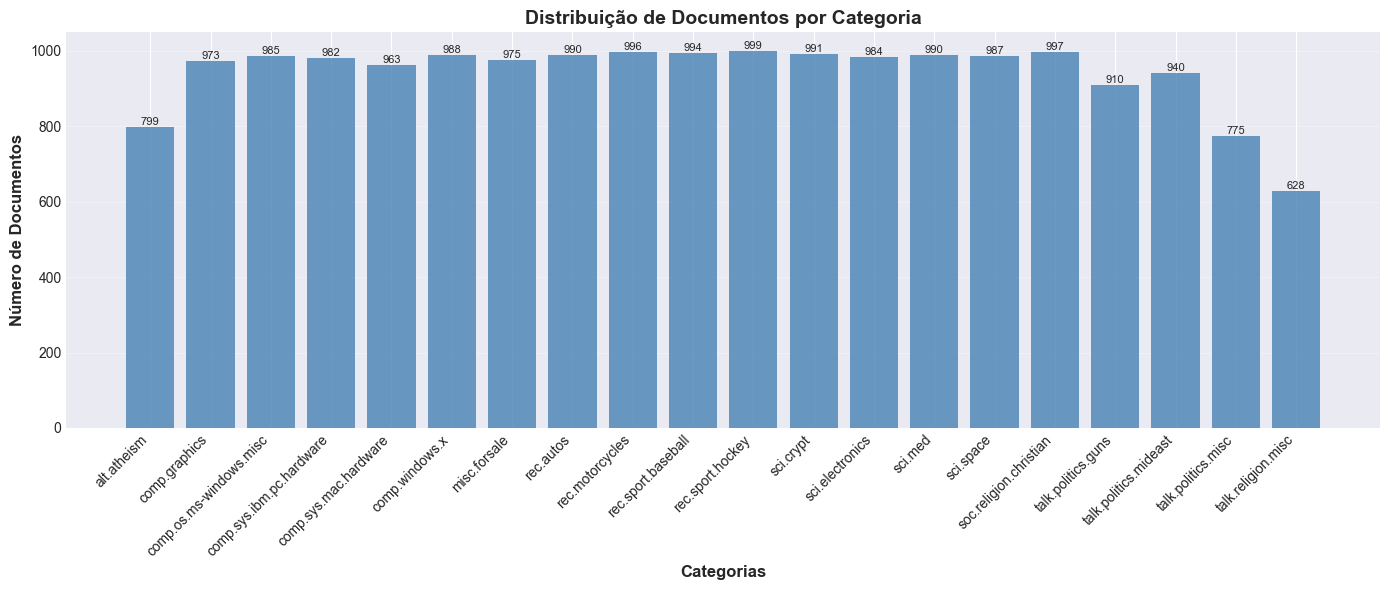


Estatísticas da distribuição:
Média de documentos por categoria: 942.30
Desvio padrão: 96.98
Min: 628, Max: 999


In [17]:
# Distribuição das classes
class_counts = pd.Series(newsgroups.target).value_counts().sort_index()
class_names = [newsgroups.target_names[i] for i in class_counts.index]

# Visualizando a distribuição
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(range(len(class_counts)), class_counts.values, color='steelblue', alpha=0.8)
ax.set_xlabel('Categorias', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Documentos', fontsize=12, fontweight='bold')
ax.set_title('Distribuição de Documentos por Categoria', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Adicionando valores nas barras
for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nEstatísticas da distribuição:")
print(f"Média de documentos por categoria: {class_counts.mean():.2f}")
print(f"Desvio padrão: {class_counts.std():.2f}")
print(f"Min: {class_counts.min()}, Max: {class_counts.max()}")

In [18]:
# Exemplo de documentos
print("Exemplos de documentos:\n")
for i in range(3):
    print(f"--- Documento {i+1} ---")
    print(f"Categoria: {newsgroups.target_names[newsgroups.target[i]]}")
    print(f"Texto (primeiros 300 caracteres):\n{newsgroups.data[i][:300]}...")
    print()

Exemplos de documentos:

--- Documento 1 ---
Categoria: rec.sport.hockey
Texto (primeiros 300 caracteres):


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
...

--- Documento 2 ---
Categoria: comp.sys.ibm.pc.hardware
Texto (primeiros 300 caracteres):
My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email...

--- Documento 3 ---
Categoria: talk.politics.mideast
Texto (primeiros 300 caracteres):




	Finally you said what you dream about. Mediterranean???? That was new....
	The area will be "greater"

## 4. Vetorização com TFIDF

In [19]:
# Criando o vetorizador TFIDF
print("Aplicando TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000,
                                   min_df=2,
                                   max_df=0.8,
                                   stop_words='english',
                                   sublinear_tf=True)

# Transformando os textos em vetores TFIDF
X = tfidf_vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

print(f"\nDimensões da matriz TFIDF: {X.shape}")
print(f"Número de features (palavras): {X.shape[1]}")
print(f"Sparsidade da matriz: {(1 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")

Aplicando TF-IDF...

Dimensões da matriz TFIDF: (18846, 10000)
Número de features (palavras): 10000
Sparsidade da matriz: 99.50%

Dimensões da matriz TFIDF: (18846, 10000)
Número de features (palavras): 10000
Sparsidade da matriz: 99.50%


## 5. Cálculo dos Priors das Classes

In [20]:
# Calculando os priors (probabilidades a priori) baseados na frequência das classes
class_counts = np.bincount(y)
class_priors = class_counts / len(y)

print("Priors das classes (probabilidades a priori):")
print("-" * 60)
for i, (name, prior) in enumerate(zip(newsgroups.target_names, class_priors)):
    print(f"{i:2d}. {name:30s} : {prior:.4f} ({class_counts[i]:4d} docs)")
    
print(f"\nSoma dos priors: {class_priors.sum():.4f}")

Priors das classes (probabilidades a priori):
------------------------------------------------------------
 0. alt.atheism                    : 0.0424 ( 799 docs)
 1. comp.graphics                  : 0.0516 ( 973 docs)
 2. comp.os.ms-windows.misc        : 0.0523 ( 985 docs)
 3. comp.sys.ibm.pc.hardware       : 0.0521 ( 982 docs)
 4. comp.sys.mac.hardware          : 0.0511 ( 963 docs)
 5. comp.windows.x                 : 0.0524 ( 988 docs)
 6. misc.forsale                   : 0.0517 ( 975 docs)
 7. rec.autos                      : 0.0525 ( 990 docs)
 8. rec.motorcycles                : 0.0528 ( 996 docs)
 9. rec.sport.baseball             : 0.0527 ( 994 docs)
10. rec.sport.hockey               : 0.0530 ( 999 docs)
11. sci.crypt                      : 0.0526 ( 991 docs)
12. sci.electronics                : 0.0522 ( 984 docs)
13. sci.med                        : 0.0525 ( 990 docs)
14. sci.space                      : 0.0524 ( 987 docs)
15. soc.religion.christian         : 0.0529 ( 997 doc

## 6. Configuração dos Classificadores

In [21]:
# Configurando os dois classificadores

# 1. MultinomialNB COM priors (baseados na distribuição das classes)
clf_with_priors = MultinomialNB(class_prior=class_priors)

# 2. MultinomialNB SEM priors (priors uniformes - todas as classes têm mesma probabilidade)
clf_without_priors = MultinomialNB(class_prior=None, fit_prior=False)

print("Classificadores configurados:")
print(f"1. MultinomialNB COM priors (baseados na distribuição)")
print(f"   - Priors: {class_priors[:3]}... (primeiros 3)")
print(f"\n2. MultinomialNB SEM priors (priors uniformes)")
print(f"   - Todos os priors = 1/{len(newsgroups.target_names)} = {1/len(newsgroups.target_names):.4f}")

Classificadores configurados:
1. MultinomialNB COM priors (baseados na distribuição)
   - Priors: [0.04239626 0.05162899 0.05226573]... (primeiros 3)

2. MultinomialNB SEM priors (priors uniformes)
   - Todos os priors = 1/20 = 0.0500


## 7. Validação Cruzada 10-Fold - MultinomialNB COM Priors

In [22]:
print("Executando validação cruzada 10-fold COM priors...")
print("Isso pode levar alguns minutos...\n")

# Realizando validação cruzada com múltiplas métricas
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_results_with_priors = cross_validate(clf_with_priors, X, y, 
                                        cv=10, 
                                        scoring=scoring,
                                        return_train_score=True,
                                        n_jobs=-1)

# Resultados
print("=" * 70)
print("RESULTADOS - MultinomialNB COM PRIORS")
print("=" * 70)
print(f"\nAcurácia:")
print(f"  Treino: {cv_results_with_priors['train_accuracy'].mean():.4f} (+/- {cv_results_with_priors['train_accuracy'].std():.4f})")
print(f"  Teste:  {cv_results_with_priors['test_accuracy'].mean():.4f} (+/- {cv_results_with_priors['test_accuracy'].std():.4f})")

print(f"\nPrecisão (macro):")
print(f"  Treino: {cv_results_with_priors['train_precision_macro'].mean():.4f} (+/- {cv_results_with_priors['train_precision_macro'].std():.4f})")
print(f"  Teste:  {cv_results_with_priors['test_precision_macro'].mean():.4f} (+/- {cv_results_with_priors['test_precision_macro'].std():.4f})")

print(f"\nRecall (macro):")
print(f"  Treino: {cv_results_with_priors['train_recall_macro'].mean():.4f} (+/- {cv_results_with_priors['train_recall_macro'].std():.4f})")
print(f"  Teste:  {cv_results_with_priors['test_recall_macro'].mean():.4f} (+/- {cv_results_with_priors['test_recall_macro'].std():.4f})")

print(f"\nF1-Score (macro):")
print(f"  Treino: {cv_results_with_priors['train_f1_macro'].mean():.4f} (+/- {cv_results_with_priors['train_f1_macro'].std():.4f})")
print(f"  Teste:  {cv_results_with_priors['test_f1_macro'].mean():.4f} (+/- {cv_results_with_priors['test_f1_macro'].std():.4f})")

print(f"\nTempo médio por fold: {cv_results_with_priors['fit_time'].mean():.2f}s")
print("=" * 70)

Executando validação cruzada 10-fold COM priors...
Isso pode levar alguns minutos...

RESULTADOS - MultinomialNB COM PRIORS

Acurácia:
  Treino: 0.8128 (+/- 0.0013)
  Teste:  0.7187 (+/- 0.0092)

Precisão (macro):
  Treino: 0.8382 (+/- 0.0012)
  Teste:  0.7391 (+/- 0.0192)

Recall (macro):
  Treino: 0.7972 (+/- 0.0014)
  Teste:  0.7012 (+/- 0.0099)

F1-Score (macro):
  Treino: 0.7957 (+/- 0.0013)
  Teste:  0.6940 (+/- 0.0108)

Tempo médio por fold: 0.11s
RESULTADOS - MultinomialNB COM PRIORS

Acurácia:
  Treino: 0.8128 (+/- 0.0013)
  Teste:  0.7187 (+/- 0.0092)

Precisão (macro):
  Treino: 0.8382 (+/- 0.0012)
  Teste:  0.7391 (+/- 0.0192)

Recall (macro):
  Treino: 0.7972 (+/- 0.0014)
  Teste:  0.7012 (+/- 0.0099)

F1-Score (macro):
  Treino: 0.7957 (+/- 0.0013)
  Teste:  0.6940 (+/- 0.0108)

Tempo médio por fold: 0.11s


## 8. Validação Cruzada 10-Fold - MultinomialNB SEM Priors

In [23]:
print("Executando validação cruzada 10-fold SEM priors...")
print("Isso pode levar alguns minutos...\n")

# Realizando validação cruzada com múltiplas métricas
cv_results_without_priors = cross_validate(clf_without_priors, X, y, 
                                           cv=10, 
                                           scoring=scoring,
                                           return_train_score=True,
                                           n_jobs=-1)

# Resultados
print("=" * 70)
print("RESULTADOS - MultinomialNB SEM PRIORS (Priors Uniformes)")
print("=" * 70)
print(f"\nAcurácia:")
print(f"  Treino: {cv_results_without_priors['train_accuracy'].mean():.4f} (+/- {cv_results_without_priors['train_accuracy'].std():.4f})")
print(f"  Teste:  {cv_results_without_priors['test_accuracy'].mean():.4f} (+/- {cv_results_without_priors['test_accuracy'].std():.4f})")

print(f"\nPrecisão (macro):")
print(f"  Treino: {cv_results_without_priors['train_precision_macro'].mean():.4f} (+/- {cv_results_without_priors['train_precision_macro'].std():.4f})")
print(f"  Teste:  {cv_results_without_priors['test_precision_macro'].mean():.4f} (+/- {cv_results_without_priors['test_precision_macro'].std():.4f})")

print(f"\nRecall (macro):")
print(f"  Treino: {cv_results_without_priors['train_recall_macro'].mean():.4f} (+/- {cv_results_without_priors['train_recall_macro'].std():.4f})")
print(f"  Teste:  {cv_results_without_priors['test_recall_macro'].mean():.4f} (+/- {cv_results_without_priors['test_recall_macro'].std():.4f})")

print(f"\nF1-Score (macro):")
print(f"  Treino: {cv_results_without_priors['train_f1_macro'].mean():.4f} (+/- {cv_results_without_priors['train_f1_macro'].std():.4f})")
print(f"  Teste:  {cv_results_without_priors['test_f1_macro'].mean():.4f} (+/- {cv_results_without_priors['test_f1_macro'].std():.4f})")

print(f"\nTempo médio por fold: {cv_results_without_priors['fit_time'].mean():.2f}s")
print("=" * 70)

Executando validação cruzada 10-fold SEM priors...
Isso pode levar alguns minutos...



RESULTADOS - MultinomialNB SEM PRIORS (Priors Uniformes)

Acurácia:
  Treino: 0.8202 (+/- 0.0014)
  Teste:  0.7237 (+/- 0.0082)

Precisão (macro):
  Treino: 0.8386 (+/- 0.0015)
  Teste:  0.7368 (+/- 0.0092)

Recall (macro):
  Treino: 0.8085 (+/- 0.0016)
  Teste:  0.7090 (+/- 0.0088)

F1-Score (macro):
  Treino: 0.8106 (+/- 0.0017)
  Teste:  0.7072 (+/- 0.0083)

Tempo médio por fold: 0.15s


## 9. Comparação dos Resultados

In [24]:
# Criando um DataFrame para comparação
comparison_data = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],
    'COM Priors (Teste)': [
        cv_results_with_priors['test_accuracy'].mean(),
        cv_results_with_priors['test_precision_macro'].mean(),
        cv_results_with_priors['test_recall_macro'].mean(),
        cv_results_with_priors['test_f1_macro'].mean()
    ],
    'SEM Priors (Teste)': [
        cv_results_without_priors['test_accuracy'].mean(),
        cv_results_without_priors['test_precision_macro'].mean(),
        cv_results_without_priors['test_recall_macro'].mean(),
        cv_results_without_priors['test_f1_macro'].mean()
    ]
}

df_comparison = pd.DataFrame(comparison_data)
df_comparison['Diferença (%)'] = ((df_comparison['COM Priors (Teste)'] - 
                                   df_comparison['SEM Priors (Teste)']) / 
                                  df_comparison['SEM Priors (Teste)'] * 100)

print("\n" + "=" * 80)
print("TABELA COMPARATIVA - Resultados de Teste (10-Fold CV)")
print("=" * 80)
print(df_comparison.to_string(index=False))
print("=" * 80)

# Identificando qual modelo é melhor
print("\n📊 Análise:")
if df_comparison['COM Priors (Teste)'][0] > df_comparison['SEM Priors (Teste)'][0]:
    print("✓ O modelo COM priors apresentou MELHOR desempenho")
    diff = (df_comparison['COM Priors (Teste)'][0] - df_comparison['SEM Priors (Teste)'][0]) * 100
    print(f"  Ganho de {diff:.2f} pontos percentuais na acurácia")
else:
    print("✓ O modelo SEM priors apresentou MELHOR desempenho")
    diff = (df_comparison['SEM Priors (Teste)'][0] - df_comparison['COM Priors (Teste)'][0]) * 100
    print(f"  Ganho de {diff:.2f} pontos percentuais na acurácia")


TABELA COMPARATIVA - Resultados de Teste (10-Fold CV)
 Métrica  COM Priors (Teste)  SEM Priors (Teste)  Diferença (%)
Acurácia            0.718666            0.723655      -0.689291
Precisão            0.739106            0.736832       0.308611
  Recall            0.701177            0.708986      -1.101437
F1-Score            0.693984            0.707175      -1.865267

📊 Análise:
✓ O modelo SEM priors apresentou MELHOR desempenho
  Ganho de 0.50 pontos percentuais na acurácia


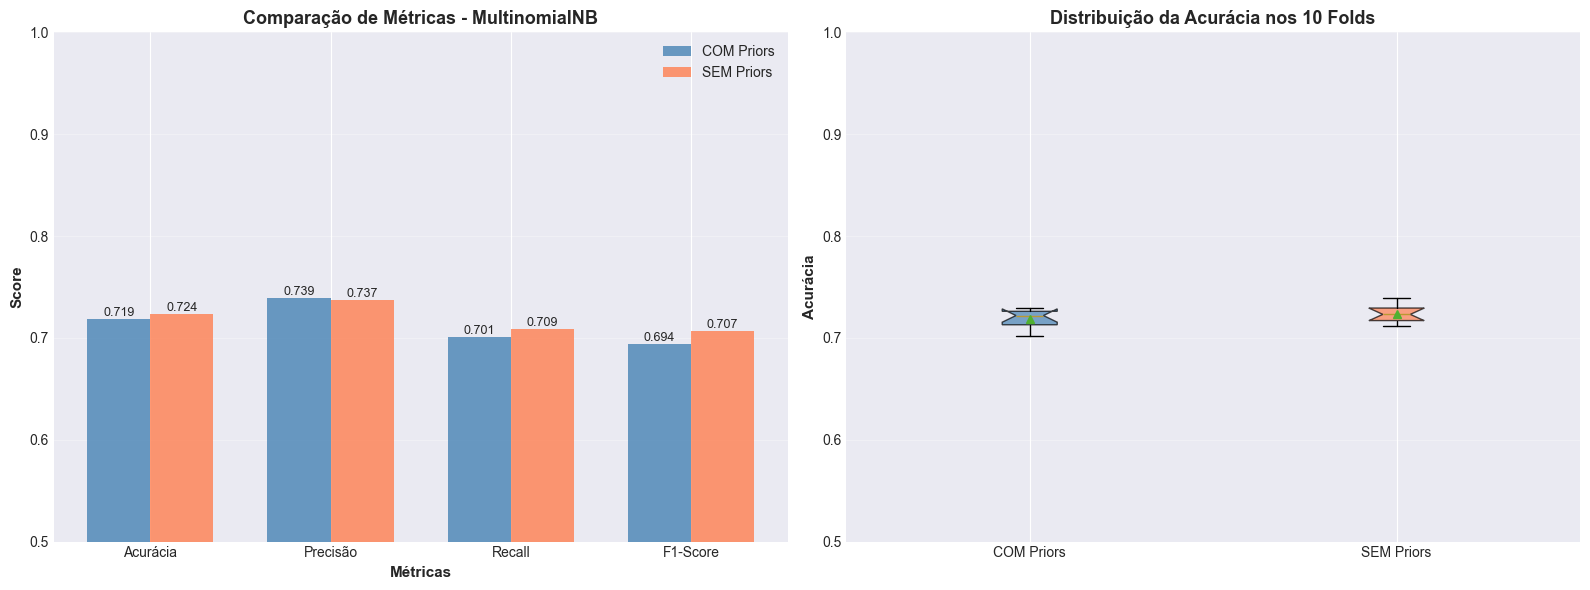

In [25]:
# Visualização gráfica da comparação
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação de métricas
metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
with_priors_scores = [
    cv_results_with_priors['test_accuracy'].mean(),
    cv_results_with_priors['test_precision_macro'].mean(),
    cv_results_with_priors['test_recall_macro'].mean(),
    cv_results_with_priors['test_f1_macro'].mean()
]
without_priors_scores = [
    cv_results_without_priors['test_accuracy'].mean(),
    cv_results_without_priors['test_precision_macro'].mean(),
    cv_results_without_priors['test_recall_macro'].mean(),
    cv_results_without_priors['test_f1_macro'].mean()
]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, with_priors_scores, width, label='COM Priors', 
                    color='steelblue', alpha=0.8)
bars2 = axes[0].bar(x + width/2, without_priors_scores, width, label='SEM Priors', 
                    color='coral', alpha=0.8)

axes[0].set_xlabel('Métricas', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Score', fontweight='bold', fontsize=11)
axes[0].set_title('Comparação de Métricas - MultinomialNB', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Adicionando valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Boxplot das acurácias por fold
data_for_boxplot = [
    cv_results_with_priors['test_accuracy'],
    cv_results_without_priors['test_accuracy']
]

bp = axes[1].boxplot(data_for_boxplot, labels=['COM Priors', 'SEM Priors'],
                     patch_artist=True, notch=True, showmeans=True)

# Colorindo as caixas
colors = ['steelblue', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_ylabel('Acurácia', fontweight='bold', fontsize=11)
axes[1].set_title('Distribuição da Acurácia nos 10 Folds', fontweight='bold', fontsize=13)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

## 10. Análise Detalhada dos Scores por Fold

In [26]:
# Tabela detalhada dos scores por fold
fold_comparison = pd.DataFrame({
    'Fold': range(1, 11),
    'COM Priors': cv_results_with_priors['test_accuracy'],
    'SEM Priors': cv_results_without_priors['test_accuracy'],
    'Diferença': cv_results_with_priors['test_accuracy'] - cv_results_without_priors['test_accuracy']
})

print("\n" + "=" * 70)
print("ACURÁCIA POR FOLD - Validação Cruzada 10-Fold")
print("=" * 70)
print(fold_comparison.to_string(index=False))
print("=" * 70)
print(f"\nMédia COM Priors:    {fold_comparison['COM Priors'].mean():.4f}")
print(f"Média SEM Priors:    {fold_comparison['SEM Priors'].mean():.4f}")
print(f"Diferença Média:     {fold_comparison['Diferença'].mean():.4f}")
print(f"\nDesvio Padrão COM:   {fold_comparison['COM Priors'].std():.4f}")
print(f"Desvio Padrão SEM:   {fold_comparison['SEM Priors'].std():.4f}")
print("=" * 70)


ACURÁCIA POR FOLD - Validação Cruzada 10-Fold
 Fold  COM Priors  SEM Priors  Diferença
    1    0.726260    0.732095  -0.005836
    2    0.705040    0.711936  -0.006897
    3    0.720955    0.719894   0.001061
    4    0.729443    0.738992  -0.009549
    5    0.716180    0.720424  -0.004244
    6    0.726790    0.725729   0.001061
    7    0.701699    0.713907  -0.012208
    8    0.725584    0.729830  -0.004246
    9    0.711783    0.716030  -0.004246
   10    0.722930    0.727707  -0.004777

Média COM Priors:    0.7187
Média SEM Priors:    0.7237
Diferença Média:     -0.0050

Desvio Padrão COM:   0.0097
Desvio Padrão SEM:   0.0087


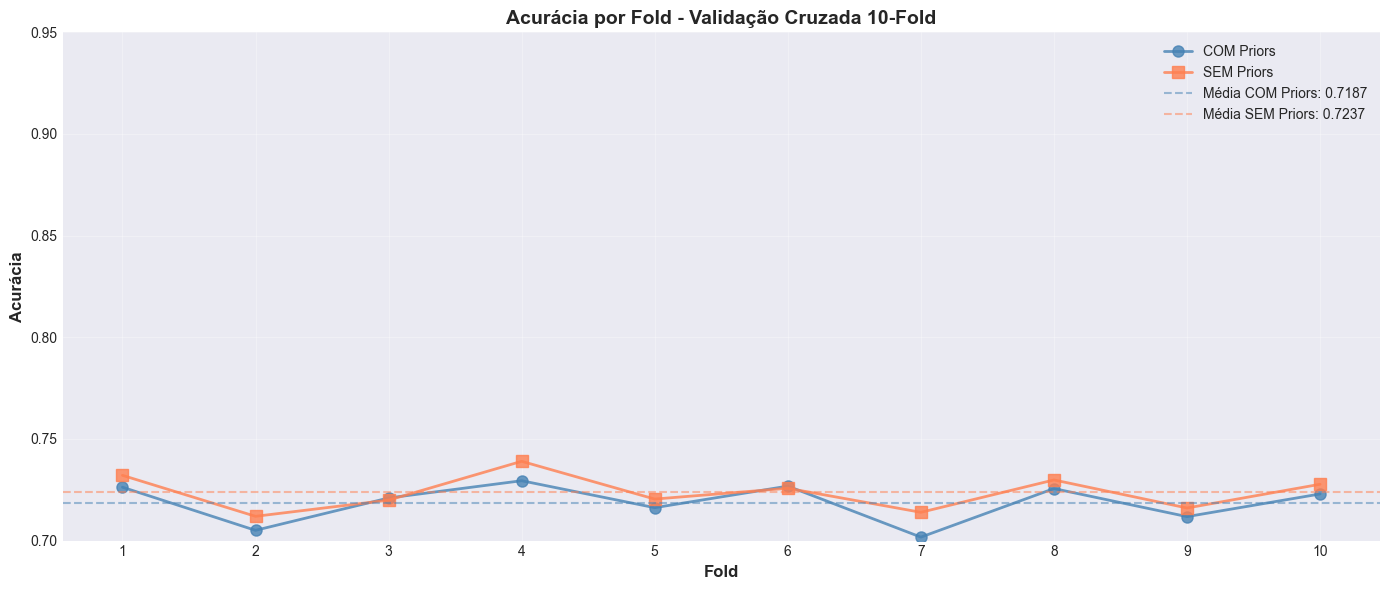

In [27]:
# Gráfico de linha mostrando a evolução por fold
fig, ax = plt.subplots(figsize=(14, 6))

folds = range(1, 11)
ax.plot(folds, cv_results_with_priors['test_accuracy'], 
        marker='o', linewidth=2, markersize=8, label='COM Priors', 
        color='steelblue', alpha=0.8)
ax.plot(folds, cv_results_without_priors['test_accuracy'], 
        marker='s', linewidth=2, markersize=8, label='SEM Priors', 
        color='coral', alpha=0.8)

# Linhas de média
ax.axhline(y=cv_results_with_priors['test_accuracy'].mean(), 
          color='steelblue', linestyle='--', linewidth=1.5, alpha=0.5,
          label=f"Média COM Priors: {cv_results_with_priors['test_accuracy'].mean():.4f}")
ax.axhline(y=cv_results_without_priors['test_accuracy'].mean(), 
          color='coral', linestyle='--', linewidth=1.5, alpha=0.5,
          label=f"Média SEM Priors: {cv_results_without_priors['test_accuracy'].mean():.4f}")

ax.set_xlabel('Fold', fontweight='bold', fontsize=12)
ax.set_ylabel('Acurácia', fontweight='bold', fontsize=12)
ax.set_title('Acurácia por Fold - Validação Cruzada 10-Fold', fontweight='bold', fontsize=14)
ax.set_xticks(folds)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.7, 0.95])

plt.tight_layout()
plt.show()

## 11. Teste Estatístico - Teste T Pareado

In [28]:
from scipy import stats

# Realizando teste t pareado
t_statistic, p_value = stats.ttest_rel(
    cv_results_with_priors['test_accuracy'],
    cv_results_without_priors['test_accuracy']
)

print("\n" + "=" * 70)
print("TESTE T PAREADO - Comparação das Acurácias")
print("=" * 70)
print(f"\nHipótese Nula (H0): Não há diferença significativa entre os modelos")
print(f"Hipótese Alternativa (H1): Há diferença significativa entre os modelos")
print(f"\nEstatística t: {t_statistic:.4f}")
print(f"Valor-p: {p_value:.6f}")
print(f"Nível de significância (α): 0.05")

if p_value < 0.05:
    print(f"\n✓ CONCLUSÃO: Rejeita H0 (p-value = {p_value:.6f} < 0.05)")
    print("  Há diferença ESTATISTICAMENTE SIGNIFICATIVA entre os modelos.")
    if cv_results_with_priors['test_accuracy'].mean() > cv_results_without_priors['test_accuracy'].mean():
        print("  O modelo COM priors é significativamente MELHOR.")
    else:
        print("  O modelo SEM priors é significativamente MELHOR.")
else:
    print(f"\n✗ CONCLUSÃO: Não rejeita H0 (p-value = {p_value:.6f} >= 0.05)")
    print("  NÃO há diferença estatisticamente significativa entre os modelos.")
    
print("=" * 70)


TESTE T PAREADO - Comparação das Acurácias

Hipótese Nula (H0): Não há diferença significativa entre os modelos
Hipótese Alternativa (H1): Há diferença significativa entre os modelos

Estatística t: -3.8361
Valor-p: 0.003990
Nível de significância (α): 0.05

✓ CONCLUSÃO: Rejeita H0 (p-value = 0.003990 < 0.05)
  Há diferença ESTATISTICAMENTE SIGNIFICATIVA entre os modelos.
  O modelo SEM priors é significativamente MELHOR.
